In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [200]:
L=2
local_dim=2
bond_dim=1

In [201]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [202]:
fname="samples_ghz_plus_z_basis_only_L=4_Nmeasure=100000.npy"
samples = np.load(fname)
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)


In [203]:
from torch.utils.data import TensorDataset, DataLoader

In [204]:
ds = TensorDataset(samples_tr)

In [205]:
batch_size = 1024
lr = .01

In [206]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [207]:
s = torch.zeros([1, L],dtype=torch.long)

In [208]:
losses = []

In [209]:
grads = []

In [210]:
eps = 100

In [211]:
def sgd_step_at_site(mps, site_index, cutoff=1e-10, normalize='left'):
    """Perform SGD step WRT two-site blob with left index at the site specified"""
    psi.gauge_to(site_index)
    #two-site blob matrix at the site
    A = psi.merge(i).numpy()
    #gradient of the log-prob WRT that complex matrix
    #note that A has to updated from the conjugate!
    g=psi.grad_twosite_logprob(i, s).numpy().conj()
    grads.append(g)
    #perform gradient descent step, insert back into MPS
    A = A - 2 * lr * g
    psi.set_sites_from_twosite(i, A,cutoff=cutoff,normalize='left')
    with torch.no_grad():
        losses.append(psi.nll_loss(s))


In [212]:
for __ in range(eps):
    for i in range(L-1):
        sgd_step_at_site(psi, i, cutoff=1e-10,normalize='left')   
    for i in range(L-2, -1,-1):
        sgd_step_at_site(psi, i, cutoff=1e-10,normalize='right')   
        
        
#     for i in range(L-2, -1,-1):
#         print(i)
#         psi.gauge_to(i)
#         A = psi.merge(i).numpy()
#         g=psi.grad_twosite_logprob(i, s).numpy().conj()
#         A = A - 2 * lr * g
#         psi.set_sites_from_twosite(i, A,cutoff=1e-3,normalize='right')
#         with torch.no_grad():
#             losses.append(psi.nll_loss(s))




In [213]:
import matplotlib.pyplot as plt

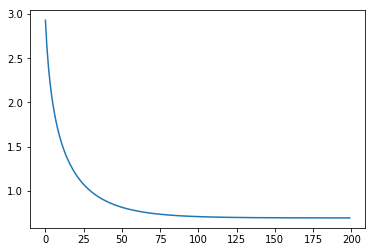

In [214]:
%matplotlib inline
plt.plot(losses)

In [215]:
print(psi.shape)

[(1, 2), (2, 1)]


In [216]:
from tools import generate_binary_space

In [217]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [218]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1]) has probability 0.5060
tensor([1, 0]) has probability 0.0001
tensor([0, 1]) has probability 0.0000
tensor([0, 0]) has probability 0.4999


In [225]:
grads[0]

array([[[[3.4078872 -1.4400448j ]],

        [[0.08222242-0.21912834j]]],


       [[[0.50632715+0.4674109j ]],

        [[3.0048664 -1.496114j  ]]]], dtype=complex64)